### Import packages

In [43]:
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow_probability as tfp
from sklearn.decomposition import PCA
import plotly.express as px
import pandas as pd

In [2]:
import scipy.io
from tqdm import trange, tqdm
from absl import app
from absl import flags
import collections
import gzip
import tarfile
import tempfile
import urllib
import zipfile

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"

# Lines dataset

In [4]:
def draw_line(angle, height, width, w=2.):
    m = np.zeros((height, width, 1))
    x0 = height*0.5
    y0 = width*0.5
    x1 = x0 + (x0 - 1) * math.cos(-angle)
    y1 = y0 + (y0 - 1) * math.sin(-angle)
    flip = False
    if abs(y0 - y1) < abs(x0 - x1):
        x0, x1, y0, y1 = y0, y1, x0, x1
        flip = True
    if y1 < y0:
        x0, x1, y0, y1 = x1, x0, y1, y0
    x0, x1 = x0 - w / 2, x1 - w / 2
    dx = x1 - x0
    dy = y1 - y0
    ds = dx / dy if dy != 0 else 0
    yi = int(math.ceil(y0)), int(y1)
    points = []
    for y in range(int(y0), int(math.ceil(y1))):
        if y < yi[0]:
            weight = yi[0] - y0
        elif y > yi[1]:
            weight = y1 - yi[1]
        else:
            weight = 1
        xs = x0 + (y - y0 - .5) * ds
        xe = xs + w
        xi = int(math.ceil(xs)), int(xe)
        if xi[0] != xi[1]:
            points.append((y, slice(xi[0], xi[1]), weight))
        if xi[0] != xs:
            points.append((y, int(xs), weight * (xi[0] - xs)))
        if xi[1] != xe:
            points.append((y, xi[1], weight * (xe - xi[1])))
    if flip:
        points = [(x, y, z) for y, x, z in points]
    for y, x, z in points:
        m[y, x] += 2 * z
    m -= 1
    m = (m+1)/2
    m = m.clip(0, 1)
    return m

(32, 32, 1)


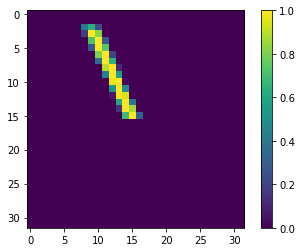

In [5]:
plt.imshow(draw_line(2, 32, 32))
plt.colorbar()
print(draw_line(2, 32, 32).shape)

In [41]:
# 2^24 is too large for our gpu
# use 2^12
dataset = np.empty((2**12,32,32,1), dtype='float32')
angles = np.empty((2**12), dtype='float32')
for i in range(2**12):
    angle = 2 * math.pi * np.random.random()
    dataset[i,:,:,:] = draw_line(angle, 32, 32)
    angles[i] = angle
dataset_tf = tf.data.Dataset.from_tensor_slices(dataset).batch(64)    

# Different autoencoders

### Baseline

In [7]:
class Baseline_encoder(tf.keras.Model):
    def __init__(self): 
        super(Baseline_encoder, self).__init__(name='baseline_encoder')
        self.c1 = tf.keras.layers.Conv2D(1,(3,3),padding='same',name='c1',activation=tf.keras.layers.LeakyReLU(0.2))
        self.c2 = tf.keras.layers.Conv2D(2,(3,3),padding='same',name='c2',activation=tf.keras.layers.LeakyReLU(0.2))
        self.ap1 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),name='ap1')
        
        self.c3 = tf.keras.layers.Conv2D(2,(3,3),padding='same',name='c3',activation=tf.keras.layers.LeakyReLU(0.2))
        self.c4 = tf.keras.layers.Conv2D(4,(3,3),padding='same',name='c4',activation=tf.keras.layers.LeakyReLU(0.2))
        self.ap2 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),name='ap2')
        
        self.c5 = tf.keras.layers.Conv2D(4,(3,3),padding='same',name='c5',activation=tf.keras.layers.LeakyReLU(0.2))
        self.c6 = tf.keras.layers.Conv2D(8,(3,3),padding='same',name='c6',activation=tf.keras.layers.LeakyReLU(0.2))
        self.ap3 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),name='ap3')
        
        self.c7 = tf.keras.layers.Conv2D(8,(3,3),padding='same',name='c7',activation=tf.keras.layers.LeakyReLU(0.2))
        self.c8 = tf.keras.layers.Conv2D(16,(3,3),padding='same',name='c8',activation=tf.keras.layers.LeakyReLU(0.2))
        self.ap4 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),name='ap4')

        self.c9 = tf.keras.layers.Conv2D(16,(3,3),padding='same',name='c9',activation=tf.keras.layers.LeakyReLU(0.2))
        self.c10 = tf.keras.layers.Conv2D(32,(3,3),padding='same',name='c10',activation=tf.keras.layers.LeakyReLU(0.2))
        self.ap5 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),name='ap5')
        
        self.c11 = tf.keras.layers.Conv2D(32,(3,3),padding='same',name='c11',activation=tf.keras.layers.LeakyReLU(0.2))
        self.c12 = tf.keras.layers.Conv2D(64,(3,3),padding='same',name='c12')     
        
    def call(self, x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.ap1(x)
        x = self.c3(x)
        x = self.c4(x)
        x = self.ap2(x)
        x = self.c5(x)
        x = self.c6(x)
        x = self.ap3(x)
        x = self.c7(x)
        x = self.c8(x)
        x = self.ap4(x)
        x = self.c9(x)
        x = self.c10(x)
        x = self.ap5(x)
        x = self.c11(x)
        x = self.c12(x)
        return x
    
class Baseline_decoder(tf.keras.Model):
    def __init__(self): 
        super(Baseline_decoder, self).__init__(name='baseline_decoder')
        leaky_relu = tf.keras.layers.LeakyReLU(0.2)
        lecun_normal = tf.keras.initializers.LecunNormal()
        self.c1 = tf.keras.layers.Conv2D(64,(3,3),padding='same',activation=tf.keras.layers.LeakyReLU(0.2))
        self.c2 = tf.keras.layers.Conv2D(64,(3,3),padding='same',activation=tf.keras.layers.LeakyReLU(0.2))
        self.us1 = tf.keras.layers.UpSampling2D((2, 2), interpolation='nearest')
        
        self.c3 = tf.keras.layers.Conv2D(32,(3,3),padding='same',activation=tf.keras.layers.LeakyReLU(0.2))
        self.c4 = tf.keras.layers.Conv2D(32,(3,3),padding='same',activation=tf.keras.layers.LeakyReLU(0.2))
        self.us2 = tf.keras.layers.UpSampling2D((2, 2), interpolation='nearest')
        
        self.c5 = tf.keras.layers.Conv2D(16,(3,3),padding='same',activation=tf.keras.layers.LeakyReLU(0.2))
        self.c6 = tf.keras.layers.Conv2D(16,(3,3),padding='same',activation=tf.keras.layers.LeakyReLU(0.2))
        self.us3 = tf.keras.layers.UpSampling2D((2, 2), interpolation='nearest')
        
        self.c7 = tf.keras.layers.Conv2D(8,(3,3),padding='same',activation=tf.keras.layers.LeakyReLU(0.2))
        self.c8 = tf.keras.layers.Conv2D(8,(3,3),padding='same',activation=tf.keras.layers.LeakyReLU(0.2))
        self.us4 = tf.keras.layers.UpSampling2D((2, 2), interpolation='nearest')
        
        self.c9 = tf.keras.layers.Conv2D(4,(3,3),padding='same',activation=tf.keras.layers.LeakyReLU(0.2))
        self.c10 = tf.keras.layers.Conv2D(4,(3,3),padding='same',activation=tf.keras.layers.LeakyReLU(0.2))
        self.us5 = tf.keras.layers.UpSampling2D((2, 2), interpolation='nearest')
        
        self.c11 = tf.keras.layers.Conv2D(2,(3,3),padding='same',activation=tf.keras.layers.LeakyReLU(0.2))
        self.c12 = tf.keras.layers.Conv2D(1,(3,3),padding='same')     

    def call(self, x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.us1(x)
        x = self.c3(x)
        x = self.c4(x)
        x = self.us2(x)
        x = self.c5(x)
        x = self.c6(x)
        x = self.us3(x)
        x = self.c7(x)
        x = self.c8(x)
        x = self.us4(x)
        x = self.c9(x)
        x = self.c10(x)
        x = self.us5(x)
        x = self.c11(x)
        x = self.c12(x)
        return x

class Baseline(tf.keras.Model):
    def __init__(self): 
        super(Baseline, self).__init__(name='baseline')
        self.encoder = Baseline_encoder()
        self.decoder = Baseline_decoder()
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)      
        return x

### Dropout

In [8]:
class Dropout(tf.keras.Model):
    def __init__(self): 
        super(Dropout, self).__init__(name='dropout')
        self.encoder = Baseline_encoder()
        self.decoder = Baseline_decoder()
        self.drop = tf.keras.layers.Dropout(0.5)  
    def call(self, x):
        x = self.encoder(x)
        x = self.drop(x)
        x = self.decoder(x)      
        return x

### Denoising

In [9]:
class Denoising(tf.keras.Model):
    def __init__(self):
        super(Denoising, self).__init__(name='denoising')
        self.noise = tf.keras.layers.GaussianNoise(0.2)  
        self.encoder = Baseline_encoder()
        self.decoder = Baseline_decoder()
    def call(self, x):
        x = self.noise(x)
        x = self.encoder(x)
        x = self.decoder(x)      
        return x

### VAE

In [18]:
class VAE_encoder(tf.keras.Model):
    def __init__(self): 
        super(VAE_encoder, self).__init__(name='vae_encoder')
        self.c1 = tf.keras.layers.Conv2D(1,(3,3),padding='same',name='c1',activation=tf.keras.layers.LeakyReLU(0.2))
        self.c2 = tf.keras.layers.Conv2D(2,(3,3),padding='same',name='c2',activation=tf.keras.layers.LeakyReLU(0.2))
        self.ap1 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),name='ap1')
        
        self.c3 = tf.keras.layers.Conv2D(2,(3,3),padding='same',name='c3',activation=tf.keras.layers.LeakyReLU(0.2))
        self.c4 = tf.keras.layers.Conv2D(4,(3,3),padding='same',name='c4',activation=tf.keras.layers.LeakyReLU(0.2))
        self.ap2 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),name='ap2')
        
        self.c5 = tf.keras.layers.Conv2D(4,(3,3),padding='same',name='c5',activation=tf.keras.layers.LeakyReLU(0.2))
        self.c6 = tf.keras.layers.Conv2D(8,(3,3),padding='same',name='c6',activation=tf.keras.layers.LeakyReLU(0.2))
        self.ap3 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),name='ap3')
        
        self.c7 = tf.keras.layers.Conv2D(8,(3,3),padding='same',name='c7',activation=tf.keras.layers.LeakyReLU(0.2))
        self.c8 = tf.keras.layers.Conv2D(16,(3,3),padding='same',name='c8',activation=tf.keras.layers.LeakyReLU(0.2))
        self.ap4 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),name='ap4')

        self.c9 = tf.keras.layers.Conv2D(16,(3,3),padding='same',name='c9',activation=tf.keras.layers.LeakyReLU(0.2))
        self.c10 = tf.keras.layers.Conv2D(32,(3,3),padding='same',name='c10',activation=tf.keras.layers.LeakyReLU(0.2))
        self.ap5 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),name='ap5')
        
        self.c11 = tf.keras.layers.Conv2D(32,(3,3),padding='same',name='c11',activation=tf.keras.layers.LeakyReLU(0.2))
        self.c12 = tf.keras.layers.Conv2D(64,(3,3),padding='same',name='c12')     
        
        self.d1 = tf.keras.layers.Dense(128)
    def call(self, x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.ap1(x)
        x = self.c3(x)
        x = self.c4(x)
        x = self.ap2(x)
        x = self.c5(x)
        x = self.c6(x)
        x = self.ap3(x)
        x = self.c7(x)
        x = self.c8(x)
        x = self.ap4(x)
        x = self.c9(x)
        x = self.c10(x)
        x = self.ap5(x)
        x = self.c11(x)
        x = self.c12(x)
        x = self.d1(x)
        return x

class VAE(tf.keras.Model):
    def __init__(self): 
        super(VAE, self).__init__(name='dropout')
        self.encoder = VAE_encoder()
        self.decoder = Baseline_decoder()
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=-1)
        return mean, logvar
    def reparameterize(self, mean, logvar):
        epsilon = tf.random.normal(shape=mean.shape)
        return mean + tf.exp(logvar/2)*epsilon 
    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_hat_parameter = model.decoder(z)
        x_hat = tfp.distributions.Bernoulli(logits=x_hat_parameter).sample()      
        return x_hat
 

### AAE

In [35]:
class AAE_discriminator(tf.keras.Model):
    def __init__(self): 
        super(AAE_discriminator, self).__init__(name='aae_discriminator')
        self.d1 = tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(0.2))
        self.d2 = tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(0.2))
        self.d3 = tf.keras.layers.Dense(1)
    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        return x
    
class AAE_encoder(tf.keras.Model):
    def __init__(self): 
        super(AAE_encoder, self).__init__(name='AAE_encoder')
        self.model = VAE_encoder()
    def call(self, x):
        return self.model(x)
    
class AAE_decoder(tf.keras.Model):
    def __init__(self): 
        super(AAE_decoder, self).__init__(name='AAE_decoder')
        self.model = Baseline_decoder()
    def call(self, x):
        return self.model(x)

### VQ-VAE

In [12]:
class AEVQVAE(train.AE):
    hparams = ClassDict(decay=0.999,
                        random_top_k=1,
                        filter_size=512,
                        soft_em=False,
                        num_samples=1,
                        epsilon=1e-5)

    def model(self, latent, depth, scales, z_log_size, beta, num_latents):
        tf.set_random_seed(123)
        x = tf.placeholder(tf.float32,
                           [None, self.height, self.width, self.colors], 'x')
        l = tf.placeholder(tf.float32, [None, self.nclass], 'label')
        h = tf.placeholder(
            tf.float32,
            [None, self.height >> scales, self.width >> scales, latent], 'h')

        def decode_fn(h):
            with tf.variable_scope('vqvae', reuse=tf.AUTO_REUSE):
                h2 = tf.expand_dims(tf.layers.flatten(h), axis=1)
                h2 = tf.layers.dense(h2, self.hparams.hidden_size * num_latents)
                d = bneck.discrete_bottleneck(h2)
                y = layers.decoder(tf.reshape(d['dense'], tf.shape(h)),
                                   scales, depth, self.colors, 'ae_decoder')
                return y, d

        self.hparams.hidden_size = (
                    (self.height >> scales) * (self.width >> scales) * latent)
        self.hparams.z_size = z_log_size
        self.hparams.num_residuals = 1
        self.hparams.num_blocks = 1
        self.hparams.beta = beta
        self.hparams.ema = True
        bneck = DiscreteBottleneck(self.hparams)
        encode = layers.encoder(x, scales, depth, latent, 'ae_encoder')
        decode = decode_fn(h)[0]
        ae, d = decode_fn(encode)
        loss_ae = tf.losses.mean_squared_error(x, ae)

        utils.HookReport.log_tensor(tf.sqrt(loss_ae) * 127.5, 'rmse')
        utils.HookReport.log_tensor(loss_ae, 'loss_ae')
        utils.HookReport.log_tensor(d['loss'], 'vqvae_loss')

        xops = classifiers.single_layer_classifier(
            tf.stop_gradient(d['dense']), l, self.nclass)
        xloss = tf.reduce_mean(xops.loss)
        utils.HookReport.log_tensor(xloss, 'classify_latent')

        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops + [d['discrete']]):
            train_op = tf.train.AdamOptimizer(FLAGS.lr).minimize(
                loss_ae + xloss + d['loss'], tf.train.get_global_step())
        ops = train.AEOps(x, h, l, encode, decode, ae, train_op,
                          classify_latent=xops.output)

        n_interpolations = 16
        n_images_per_interpolation = 16

        def gen_images():
            return self.make_sample_grid_and_save(
                ops, interpolation=n_interpolations,
                height=n_images_per_interpolation)

        recon, inter, slerp, samples = tf.py_func(
            gen_images, [], [tf.float32]*4)
        tf.summary.image('reconstruction', tf.expand_dims(recon, 0))
        tf.summary.image('interpolation', tf.expand_dims(inter, 0))
        tf.summary.image('slerp', tf.expand_dims(slerp, 0))
        tf.summary.image('samples', tf.expand_dims(samples, 0))

        return ops

NameError: name 'train' is not defined

### ACAI

In [ ]:
class ACAI(train.AE):
    def model(self, latent, depth, scales, advweight, advdepth, reg):
        x = tf.placeholder(tf.float32,
                           [None, self.height, self.width, self.colors], 'x')
        l = tf.placeholder(tf.float32, [None, self.nclass], 'label')
        h = tf.placeholder(
            tf.float32,
            [None, self.height >> scales, self.width >> scales, latent], 'h')

        def encoder(x):
            return layers.encoder(x, scales, depth, latent, 'ae_enc')

        def decoder(h):
            v = layers.decoder(h, scales, depth, self.colors, 'ae_dec')
            return v

        def disc(x):
            return tf.reduce_mean(
                layers.encoder(x, scales, advdepth, latent, 'disc'),
                axis=[1, 2, 3])

        encode = encoder(x)
        decode = decoder(h)
        ae = decoder(encode)
        loss_ae = tf.losses.mean_squared_error(x, ae)

        alpha = tf.random_uniform([tf.shape(encode)[0], 1, 1, 1], 0, 1)
        alpha = 0.5 - tf.abs(alpha - 0.5)  # Make interval [0, 0.5]
        encode_mix = alpha * encode + (1 - alpha) * encode[::-1]
        decode_mix = decoder(encode_mix)

        loss_disc = tf.reduce_mean(
            tf.square(disc(decode_mix) - alpha[:, 0, 0, 0]))
        loss_disc_real = tf.reduce_mean(tf.square(disc(ae + reg * (x - ae))))
        loss_ae_disc = tf.reduce_mean(tf.square(disc(decode_mix)))

        utils.HookReport.log_tensor(tf.sqrt(loss_ae) * 127.5, 'rmse')
        utils.HookReport.log_tensor(loss_ae, 'loss_ae')
        utils.HookReport.log_tensor(loss_disc, 'loss_disc')
        utils.HookReport.log_tensor(loss_ae_disc, 'loss_ae_disc')
        utils.HookReport.log_tensor(loss_disc_real, 'loss_disc_real')

        xops = classifiers.single_layer_classifier(
            tf.stop_gradient(encode), l, self.nclass)
        xloss = tf.reduce_mean(xops.loss)
        utils.HookReport.log_tensor(xloss, 'classify_latent')

        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        ae_vars = tf.global_variables('ae_')
        disc_vars = tf.global_variables('disc')
        xl_vars = tf.global_variables('single_layer_classifier')
        with tf.control_dependencies(update_ops):
            train_ae = tf.train.AdamOptimizer(FLAGS.lr).minimize(
                loss_ae + advweight * loss_ae_disc,
                var_list=ae_vars)
            train_d = tf.train.AdamOptimizer(FLAGS.lr).minimize(
                loss_disc + loss_disc_real,
                var_list=disc_vars)
            train_xl = tf.train.AdamOptimizer(FLAGS.lr).minimize(
                xloss, tf.train.get_global_step(), var_list=xl_vars)
        ops = train.AEOps(x, h, l, encode, decode, ae,
                          tf.group(train_ae, train_d, train_xl),
                          classify_latent=xops.output)

        n_interpolations = 16
        n_images_per_interpolation = 16

        def gen_images():
            return self.make_sample_grid_and_save(
                ops, interpolation=n_interpolations,
                height=n_images_per_interpolation)

        recon, inter, slerp, samples = tf.py_func(
            gen_images, [], [tf.float32] * 4)
        tf.summary.image('reconstruction', tf.expand_dims(recon, 0))
        tf.summary.image('interpolation', tf.expand_dims(inter, 0))
        tf.summary.image('slerp', tf.expand_dims(slerp, 0))
        tf.summary.image('samples', tf.expand_dims(samples, 0))

        if FLAGS.dataset == 'lines32':
            batched = (n_interpolations, 32, n_images_per_interpolation, 32, 1)
            batched_interp = tf.transpose(
                tf.reshape(inter, batched), [0, 2, 1, 3, 4])
            mean_distance, mean_smoothness = tf.py_func(
                eval.line_eval, [batched_interp], [tf.float32, tf.float32])
            tf.summary.scalar('mean_distance', mean_distance)
            tf.summary.scalar('mean_smoothness', mean_smoothness)

        return ops


# Train

### Baseline

In [80]:
model = Baseline()
model.load_weights('./checkpoint/baseline')
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        clear_output(wait=True)
        print("For epoch {:d}, loss is {:f}.".format(epoch, logs["loss"]))

In [81]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-08)
model.compile(loss='mse',optimizer=Adam)

In [82]:
model.fit(dataset, dataset, batch_size=64,epochs=10,verbose=0,callbacks=CustomCallback())

For epoch 9, loss is 0.000996.


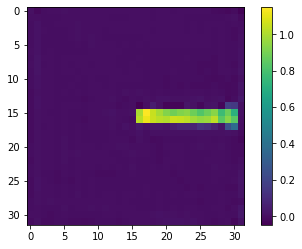

In [83]:
angle = 2*math.pi*np.random.random()
angle = 0
plt.imshow(model(draw_line(angle, 32, 32)[np.newaxis,:,:,:])[0,:,:,:])
plt.colorbar()

In [84]:
#model.save_weights('./checkpoint/baseline')

(4096, 1, 1, 64)
(4096,)


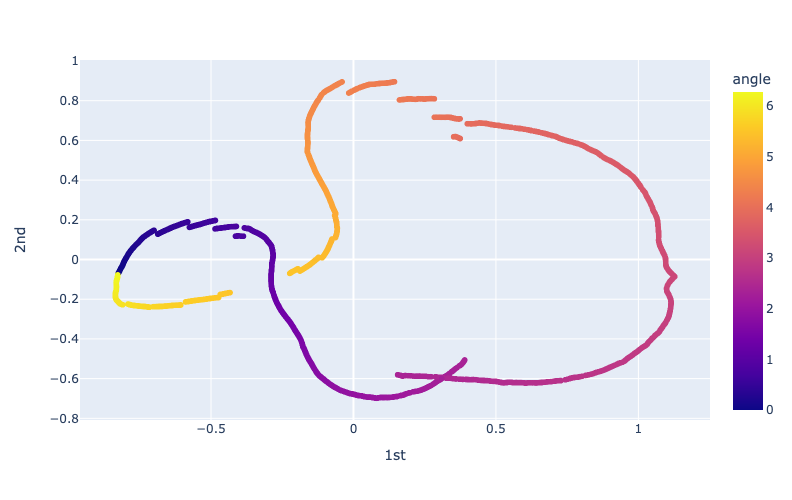

In [86]:
Ns = model.encoder(dataset).numpy()
print(Ns.shape)
N_reshaped = Ns.reshape(-1,64)
print(angles.shape)
df_angles = pd.DataFrame(angles,columns=['angle'])
pca = PCA(2)
pca_N = pca.fit_transform(N_reshaped)
df = pd.DataFrame(pca_N, columns = ['1st','2nd'])
df = pd.concat([df,df_angles],axis=1)
fig = px.scatter(df, x='1st', y='2nd', color='angle')
fig.update_layout(height=500)
fig.show()

### Dropout

In [71]:
model = Dropout()
model.load_weights('./checkpoint/dropout')
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        clear_output(wait=True)
        print("For epoch {:d}, loss is {:f}.".format(epoch, logs["loss"]))

In [72]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-08)
model.compile(loss='mse',optimizer=Adam)

In [73]:
model.fit(dataset, dataset, batch_size=64,epochs=1,verbose=0,callbacks=CustomCallback())

For epoch 0, loss is 0.001411.


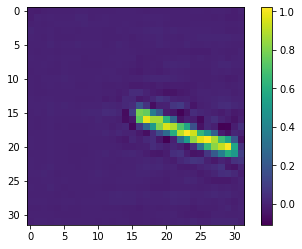

In [74]:
angle = 2*math.pi*np.random.random()
angle = 0
plt.imshow(model(draw_line(angle, 32, 32)[np.newaxis,:,:,:])[0,:,:,:])
plt.colorbar()

In [75]:
#model.save_weights('./checkpoint/dropout')

(4096, 1, 1, 64)
(4096,)


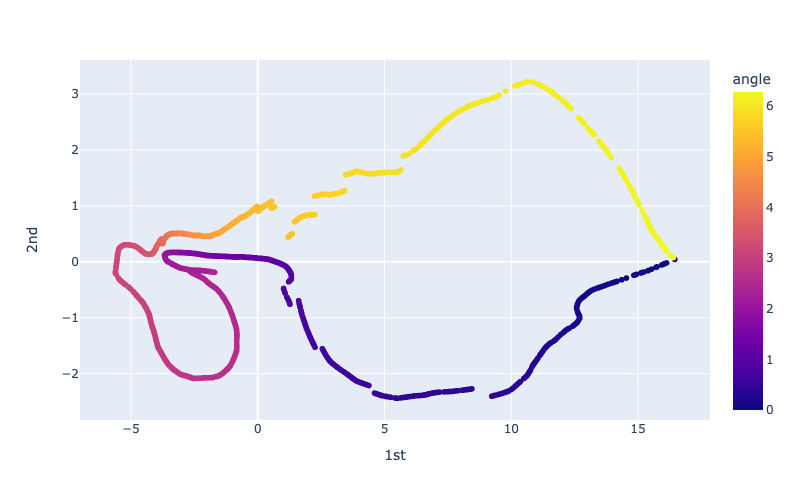

In [76]:
Ns = model.encoder(dataset).numpy()
print(Ns.shape)
N_reshaped = Ns.reshape(-1,64)
print(angles.shape)
df_angles = pd.DataFrame(angles,columns=['angle'])
pca = PCA(2)
pca_N = pca.fit_transform(N_reshaped)
df = pd.DataFrame(pca_N, columns = ['1st','2nd'])
df = pd.concat([df,df_angles],axis=1)
fig = px.scatter(df, x='1st', y='2nd', color='angle')
fig.update_layout(height=500)
fig.show()

### Denoising

In [ ]:
model = Denoising()
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        clear_output(wait=True)
        print("For epoch {:d}, loss is {:f}.".format(epoch, logs["loss"]))

In [ ]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-08)
model.compile(loss='mse',optimizer=Adam)

In [ ]:
model.fit(dataset, dataset, batch_size=64,epochs=100,verbose=0,callbacks=CustomCallback())

In [ ]:
angle = 2*math.pi*np.random.random()
x = draw_line(angle, 32, 32)
x_hat = model(x[np.newaxis,:,:,:])
#x_hat = model.noise(x[np.newaxis,:,:,:], training=True)
plt.imshow(x_hat[0,:,:,:])
plt.colorbar()

In [ ]:
#model.save_weights('./checkpoint/denoising')

### VAE

In [58]:
model = VAE()
model.load_weights('./checkpoint/vae')

In [60]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-08)

@tf.function
def log_normal_pdf(z, mean, logvar):
    tem = -0.5*tf.math.log(2*np.pi) - 0.5*logvar - 0.5*(z - mean)**2*tf.exp(-logvar)
    return tf.reduce_sum(tem, axis=[1,2,3])

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_hat_parameter = model.decoder(z)
    x_hat = tfp.distributions.Bernoulli(logits=x_hat_parameter)
    logpz = log_normal_pdf(z, 0.0, 0.0)
    logqz_x = log_normal_pdf(z, mean, logvar)
    logpx_z = tf.reduce_sum(x_hat.log_prob(x), axis=[1,2,3])
    return -tf.reduce_mean(logpx_z + 1*(logpz - logqz_x))

@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables)) 
    return loss

for epoch in range(10):
    for x in dataset_tf:
        loss = train_step(model, x, optimizer)
    clear_output(wait=True)
    print("For epoch {:d}, -ELBO is {:f}.".format(epoch, loss))

For epoch 9, -ELBO is 23.270233.


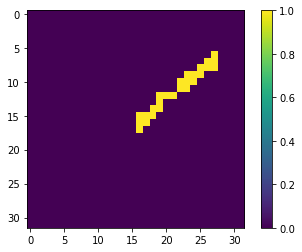

In [24]:
angle = 2*math.pi*np.random.random()
x = draw_line(angle, 32, 32)
x_hat = model(x[np.newaxis,:,:,:])
plt.imshow(x_hat[0,:,:,:])
plt.colorbar()

In [25]:
#model.save_weights('./checkpoint/vae')

(4096, 1, 1, 64)
(4096, 1, 1, 128)
(4096,)


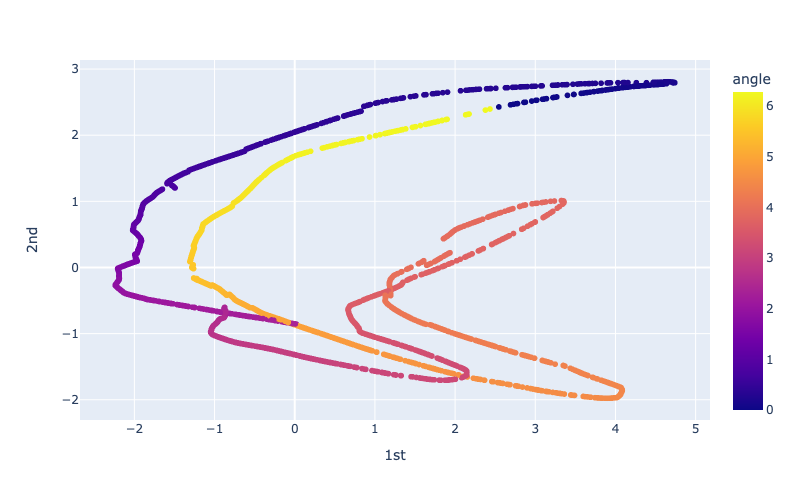

In [62]:
mean, logvar = model.encode(dataset)
print(mean.shape)
z = model.reparameterize(mean, logvar)
Ns = model.encoder(dataset).numpy()
print(Ns.shape)
N_reshaped = Ns.reshape(-1,128)
print(angles.shape)
df_angles = pd.DataFrame(angles,columns=['angle'])
pca = PCA(2)
pca_N = pca.fit_transform(N_reshaped)
df = pd.DataFrame(pca_N, columns = ['1st','2nd'])
df = pd.concat([df,df_angles],axis=1)
fig = px.scatter(df, x='1st', y='2nd', color='angle')
fig.update_layout(height=500)
fig.show()

### AAE

In [36]:
encoder = AAE_encoder()
decoder = AAE_decoder()
discriminator = AAE_discriminator()

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-08)

In [ ]:
def log_normal_pdf(z, mean, logvar):
    tem = -0.5*tf.math.log(2*np.pi) - 0.5*logvar - 0.5*(z - mean)**2*tf.exp(-logvar)
    return tf.reduce_sum(tem, axis=[1,2,3])

@tf.function
def train_step(images):
    z = encoder(x)
    reconstruct = decoder(z)
    loss_reconstruction = tf.keras.losses.MeanSquaredError()(reconstruct, x)
    
    z_priori = tf.random_normal(z.shape)
    adversary_latent = discriminator(z)
    adversary_prior = discriminator(z_priori)    
    
    adversary_loss_latents = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=adversary_latent,
            labels=tf.zeros_like(adversary_latent)))
    adversary_loss_prior = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=adversary_prior,
            labels=tf.ones_like(adversary_prior))) 
    autoencoder_loss_latents = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=adversary_latent,
            labels=tf.ones_like(adversary_latent)))  

    def _accuracy(logits, label):
        labels = tf.logical_and(label, tf.ones_like(logits, dtype=bool))
        correct = tf.equal(tf.greater(logits, 0), labels)
        return tf.reduce_mean(tf.to_float(correct))
    latent_accuracy = _accuracy(adversary_latent, False)
    prior_accuracy = _accuracy(adversary_prior, True)
    adversary_accuracy = (latent_accuracy + prior_accuracy)/2
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)      
        ae_loss = loss_reconstruction + autoencoder_loss_latents
        disc_loss = adversary_loss_prior + adversary_loss_latents
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return None

for epoch in range(1000):
    for x in dataset_tf:
        loss = train_step(x)
    clear_output(wait=True)
    print("For epoch {:d}, -ELBO is {:f}.".format(epoch, loss))